## EMA 与 MACD 配合使用

MACD 是基于 EMA 的动量指标，由快线（MACD 线）、慢线（信号线）和柱状图（Histogram）组成。

#### 使用方法：
+ 当 MACD 线（快线）上穿信号线（慢线）时，可能是买入信号。
+ 当 MACD 线下穿信号线时，可能是卖出信号。
结合 EMA（如 12 日和 26 日 EMA），可以进一步确认趋势方向。

In [47]:
# 获取数据源
import baostock as bs
import pandas as pd
import logging
import numpy as np

def get_k_data(code, start, end):
    lg = bs.login()
    # 显示登陆返回信息
    logging.info('login respond error_code:' + lg.error_code)
    logging.info('login respond  error_msg:' + lg.error_msg)
    # 获取股票数据
    rs = bs.query_history_k_data_plus(code,
                                              "date,open,high,low,close,volume",
                                              start_date=start,
                                              end_date=end,
                                              frequency="d",
                                              adjustflag="3")  # adjustflag="3"表示不复权
    data = rs.get_data()


    # 登出baostock系统
    bs.logout()

    # 创建DataFrame
    df = data[['date', 'open', 'high', 'low', 'close', 'volume']].rename(columns={'date': 'Date'})

    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # 设置日期列为索引

    # 将空字符串替换为 NaN
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].replace('', np.nan)
    # 去除包含空值的行
    df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

    # 将股价数据转换为数值类型
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


In [48]:
stock_code = "sh.603486"  # 沪深300
start_date = "2023-01-01"
end_date = "2024-12-31"

df = get_k_data(stock_code, start_date, end_date)

login success!
logout success!


In [49]:
import talib

# 计算MACD
# 解释下 MACD 的参数：fastperiod=12, slowperiod=26, signalperiod=9
# fastperiod：快速移动平均线的窗口期
# slowperiod：慢速移动平均线的窗口期
# signalperiod：MACD的窗口期

# 返回结果是什么？
# MACD：MACD线
# MACD_signal：MACD的信号线
# MACD_hist：MACD的差值，即MACD线和信号线的差值
# 怎么用？ 

df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)


# 计算20日指数移动平均线
df['EMA_20'] = talib.EMA(df['close'], timeperiod=20)

# 计算60日指数移动平均线
df['EMA_60'] = talib.EMA(df['close'], timeperiod=60)


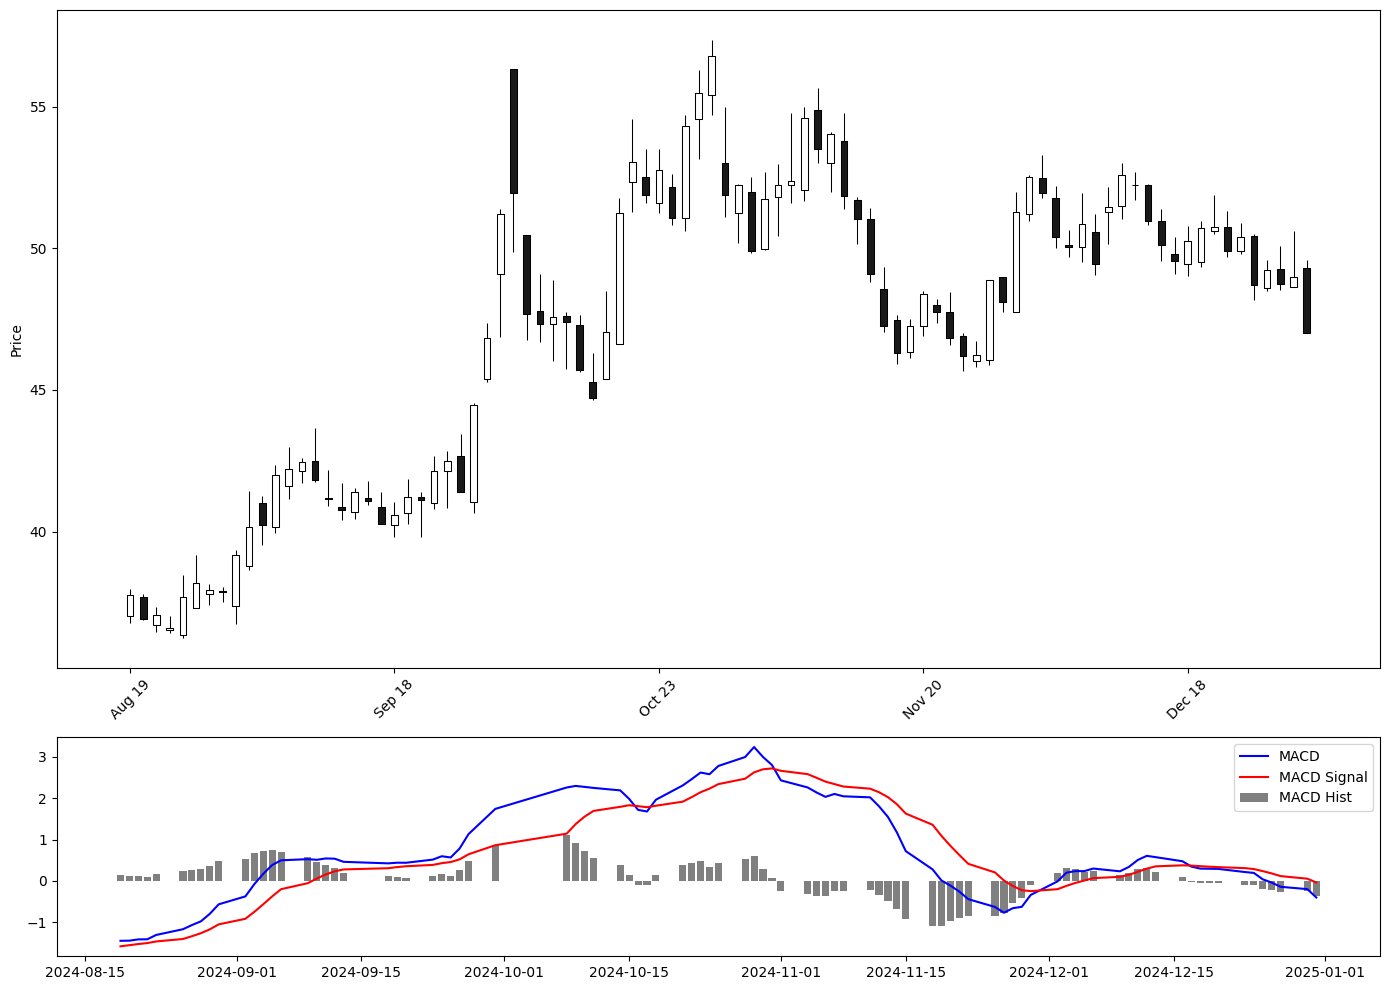

In [50]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# 绘制图表
# 绘制K线图和MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# 找到买卖点
buy_signals = (df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1))
sell_signals = (df['MACD'] < df['MACD_signal']) & (df['MACD'].shift(1) >= df['MACD_signal'].shift(1))

# 只要90天
df = df.tail(90)

# 绘制K线图
mpf.plot(df, type='candle', ax=ax1, volume=False, show_nontrading=False)

# 标记买卖点
# ax1.plot(df.index[buy_signals], df['close'][buy_signals], '^', markersize=10, color='g', label='Buy Signal')
# ax1.plot(df.index[sell_signals], df['close'][sell_signals], 'v', markersize=10, color='r', label='Sell Signal')

# 绘制MACD
ax2.plot(df.index, df['MACD'], label='MACD', color='blue')
ax2.plot(df.index, df['MACD_signal'], label='MACD Signal', color='red')
ax2.bar(df.index, df['MACD_hist'], label='MACD Hist', color='gray')
ax2.legend()

plt.tight_layout()
plt.show()